# Profile changes by run


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import xarray as xr
import cmocean
import pandas as pd 
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import pickle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

%matplotlib inline

#### Parameters:

In [35]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

isize = imax-imin
jsize = jmax-jmin

# results to plot:
folder1 = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-all-off/'
folder2 = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-all-off/'

# colours:
land_color     = '#a9a7a2'
profile_colors = ['#ff4949', '#01b9ff', '#006f99']

#### Files:

Model results

In [45]:
pfile1       = xr.open_dataset(f'{folder1}ANHA12_EXH006_5d_20150101_20151231_ptrc_T_20150101-20150105.nc')
pfile2       = xr.open_dataset(f'{folder2}ANHA12_EXH006_5d_20150101_20151231_ptrc_T_20151217-20151221.nc')
lon_model    = pfile1['nav_lon'].values
lat_model    = pfile1['nav_lat'].values
depths_model = pfile1['deptht'].values

Pb_dis1      = pfile1['dissolpb'].values
Pb_dis2      = pfile2['dissolpb'].values

Mesh

In [37]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
tmask        = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
bathy_masked = np.ma.masked_where((tmask> 0.1), tmask) 
mesh_depth   = mfile['nav_lev'].values
# mesh_bathy = np.array(mesh.variables['hdept'][0])

Observations

In [38]:
# Station coordinates and names:
stn_n = np.array(['BB1', 'BB2', 'BB3', 'CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
          'CB1', 'CB2', 'CB3', 'CB4'])
stn_i = np.array([174, 337, 316, 444, 440, 431, 515, 515, 573, 554, 692, 582, 798, 848, 887, 969])
stn_j = np.array([405, 415, 382, 370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])

# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

Pb_data = Pb_data.rename(columns={"Depth.1": "Depth BB1", "Depth.2": "Depth BB2", "Depth.3": "Depth BB3", \
                        "Depth.4": "Depth CAA1", "Depth.5": "Depth CAA2", "Depth.6": "Depth CAA3", \
                        "Depth.7": "Depth CAA4", "Depth.8": "Depth CAA5", "Depth.9": "Depth CAA6", \
                        "Depth.10": "Depth CAA7", "Depth.11": "Depth CAA8", "Depth.12": "Depth CAA9", \
                        "Depth.13": "Depth CB1", "Depth.14": "Depth CB2", "Depth.15": "Depth CB3", \
                        "Depth.16": "Depth CB4"})

Pb_data[f'Depth CAA1'][6]  = np.NaN; Pb_data[f'Depth CAA2'][5]  = np.NaN;
Pb_data[f'Depth CAA2'][6]  = np.NaN; Pb_data[f'Depth CAA6'][4]  = np.NaN;
Pb_data[f'Depth CAA8'][8]  = np.NaN; Pb_data[f'Depth CAA8'][10] = np.NaN;
Pb_data[f'Depth CAA9'][8]  = np.NaN; 
Pb_data[f'Depth CB1'][8] = np.NaN;  Pb_data[f'Depth CB1'][9] = np.NaN;
Pb_data[f'Depth CB2'][1] = np.NaN;  Pb_data[f'Depth CB3'][20] = np.NaN;
Pb_data[f'Depth CB4'][11] = np.NaN; Pb_data[f'Depth CB4'][22] = np.NaN;

bottom_depths = [np.amax(Pb_data[f'Depth {stn}']) for stn in stn_n]

In [39]:
stn_names = Pb_data['Station names'].dropna().astype('str')
obs_lons  = Pb_data['station lon'].astype('float').dropna().values
obs_lats  = Pb_data['Station lat'].astype('float').dropna().values

#### Functions

In [46]:
def station_profile(dpb1, dpb2, ax, name, extend=False, zlim=np.nan):
    
    ax.invert_yaxis()
    ax.tick_params(labelsize=6, pad=0)
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    
    # observations: -------------------------------------------------------------------------------------------
    dPb_obs   = Pb_data[name][np.isfinite(Pb_data[name])].astype('float').values*1e3
    depth_obs = Pb_data[f'Depth {name}'][np.isfinite(Pb_data[f'Depth {name}'])].astype('float').values
    
    ax.plot(dPb_obs, depth_obs, '.-', zorder=4, \
            markeredgewidth=0.5, markeredgecolor='k', color=profile_colors[0], markersize=5, linewidth=1.5)

    # model: --------------------------------------------------------------------------------------------------
    model_i = int(stn_i[stn_n==name]); model_j = int(stn_j[stn_n==name]);
    
    Pb_ij1        = dpb1[0, :, model_i, model_j]*10**12
    Pb_ij2        = dpb2[0, :, model_i, model_j]*10**12 
    Pb_ij_masked1 = np.ma.masked_where((tmask[:,model_i, model_j] < 0.1), Pb_ij1)
    Pb_ij_masked2 = np.ma.masked_where((tmask[:,model_i, model_j] < 0.1), Pb_ij2)

    # Plot profiles:  ----------------------------------------------------------------------------------------- 
    if np.isnan(zlim):
        plot_depth_lowerrange = depth_obs[-1] # deepest observation    
    else:
        plot_depth_lowerrange = zlim
    plot_depth_upperrange = 0
    ax.set_ylim([plot_depth_lowerrange*1.2, 0-(plot_depth_lowerrange*0.04)])
    
    ax.plot(Pb_ij_masked1[depths_model > plot_depth_upperrange], \
            depths_model[depths_model > plot_depth_upperrange], '-', \
            zorder=1, linewidth=1.5, color=profile_colors[1])
    
    ax.plot(Pb_ij_masked2[depths_model > plot_depth_upperrange], \
            depths_model[depths_model > plot_depth_upperrange], '-', \
            zorder=1, linewidth=1.5, color=profile_colors[2])
    
    if extend:
        ax.set_xlim([-2, 28])
        ax.set_xticks([0,10,20])
        ax.text(13, (plot_depth_lowerrange+30)*0.95, name, fontsize=6)
    else:
        ax.set_xlim([-1, 18])
        ax.set_xticks([0, 10])
        ax.text(7, (plot_depth_lowerrange+30)*0.95, name, fontsize=6)
    
    return

In [47]:
def plot_general(dpb1, dpb2, zlim=np.nan):
    
    fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-eval.pickle','rb'))

    # profile plots:
    ax1  = plt.axes([0.79, 0.17, 0.08, 0.15]) # BB1
    ax2  = plt.axes([0.79, 0.59, 0.08, 0.15]) # BB2
    ax3  = plt.axes([0.79, 0.36, 0.08, 0.15]) # BB3
    ax4  = plt.axes([0.65, 0.68, 0.08, 0.15]) # CAA1
    ax5  = plt.axes([0.65, 0.17, 0.08, 0.15]) # CAA2
    ax6  = plt.axes([0.53, 0.17, 0.08, 0.15]) # CAA3
    ax7  = plt.axes([0.295, 0.17, 0.08, 0.15]) # CAA4
    ax8  = plt.axes([0.41, 0.17, 0.08, 0.15]) # CAA5
    ax9  = plt.axes([0.41, 0.68, 0.08, 0.15]) # CAA6
    ax10 = plt.axes([0.295, 0.36, 0.08, 0.15]) # CAA7
    ax11 = plt.axes([0.165, 0.17, 0.08, 0.15]) # CAA8
    ax12 = plt.axes([0.53, 0.68, 0.08, 0.15]) # CAA9
    ax13 = plt.axes([0.165, 0.36, 0.08, 0.15]) # CB1
    ax14 = plt.axes([0.165, 0.58, 0.08, 0.15]) # CB2
    ax15 = plt.axes([0.295, 0.78, 0.08, 0.15]) # CB3
    ax16 = plt.axes([0.165, 0.78, 0.08, 0.15]) # CB4
    axes_list=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16]

    for axi in axes_list:
        axi.tick_params(labelsize=5)

    fig1  = station_profile(dpb1, dpb2, ax1,  'BB1', extend=True, zlim=zlim)
    fig2  = station_profile(dpb1, dpb2, ax2,  'BB2', extend=True, zlim=zlim)
    fig3  = station_profile(dpb1, dpb2, ax3,  'BB3', extend=True, zlim=zlim)
    fig4  = station_profile(dpb1, dpb2, ax4,  'CAA1', zlim=zlim)
    fig5  = station_profile(dpb1, dpb2, ax5,  'CAA2', zlim=zlim)
    fig6  = station_profile(dpb1, dpb2, ax6,  'CAA3', zlim=zlim)
    fig7  = station_profile(dpb1, dpb2, ax7,  'CAA4', zlim=zlim)
    fig8  = station_profile(dpb1, dpb2, ax8,  'CAA5', zlim=zlim)
    fig9  = station_profile(dpb1, dpb2, ax9,  'CAA6', zlim=zlim)
    fig10 = station_profile(dpb1, dpb2, ax10, 'CAA7', zlim=zlim)
    fig11 = station_profile(dpb1, dpb2, ax11, 'CAA8', zlim=zlim)
    fig12 = station_profile(dpb1, dpb2, ax12, 'CAA9', zlim=zlim)
    fig13 = station_profile(dpb1, dpb2, ax13, 'CB1', zlim=zlim)
    fig14 = station_profile(dpb1, dpb2, ax14, 'CB2', zlim=zlim)
    fig15 = station_profile(dpb1, dpb2, ax15, 'CB3', zlim=zlim)
    fig16 = station_profile(dpb1, dpb2, ax16, 'CB4', zlim=zlim)

    x_GEOTRACES, y_GEOTRACES = proj(obs_lons[2:18], obs_lats[2:18]) # leave out BB and K stations
    ax.scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=50, linewidth=0.5, zorder=3, edgecolor='k', color='w')

    # create lines connecting the profiles:
    coordsA = "data"
    coordsB = "data"
    for i,n in enumerate(range(2,18)):
        xy1 = (x_GEOTRACES[i], y_GEOTRACES[i])
        xy2 = (8, bottom_depths[i]/2)
        axB = axes_list[i]
        con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax, axesB=axB, \
                              coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=0.9, zorder=2)
        ax.add_artist(con)

    ax.plot(0, 0, linewidth=2.5, color=profile_colors[0], label="Observations")
    ax.plot(0, 0, linewidth=2.5, color=profile_colors[1], label="Model run 1")
    ax.plot(0, 0, linewidth=2.5, color=profile_colors[2], label="Model run 2")
    ax.legend(loc=(0.81, 1.03), fontsize=7, frameon=False, handlelength=0.7)

    return

#### Figure

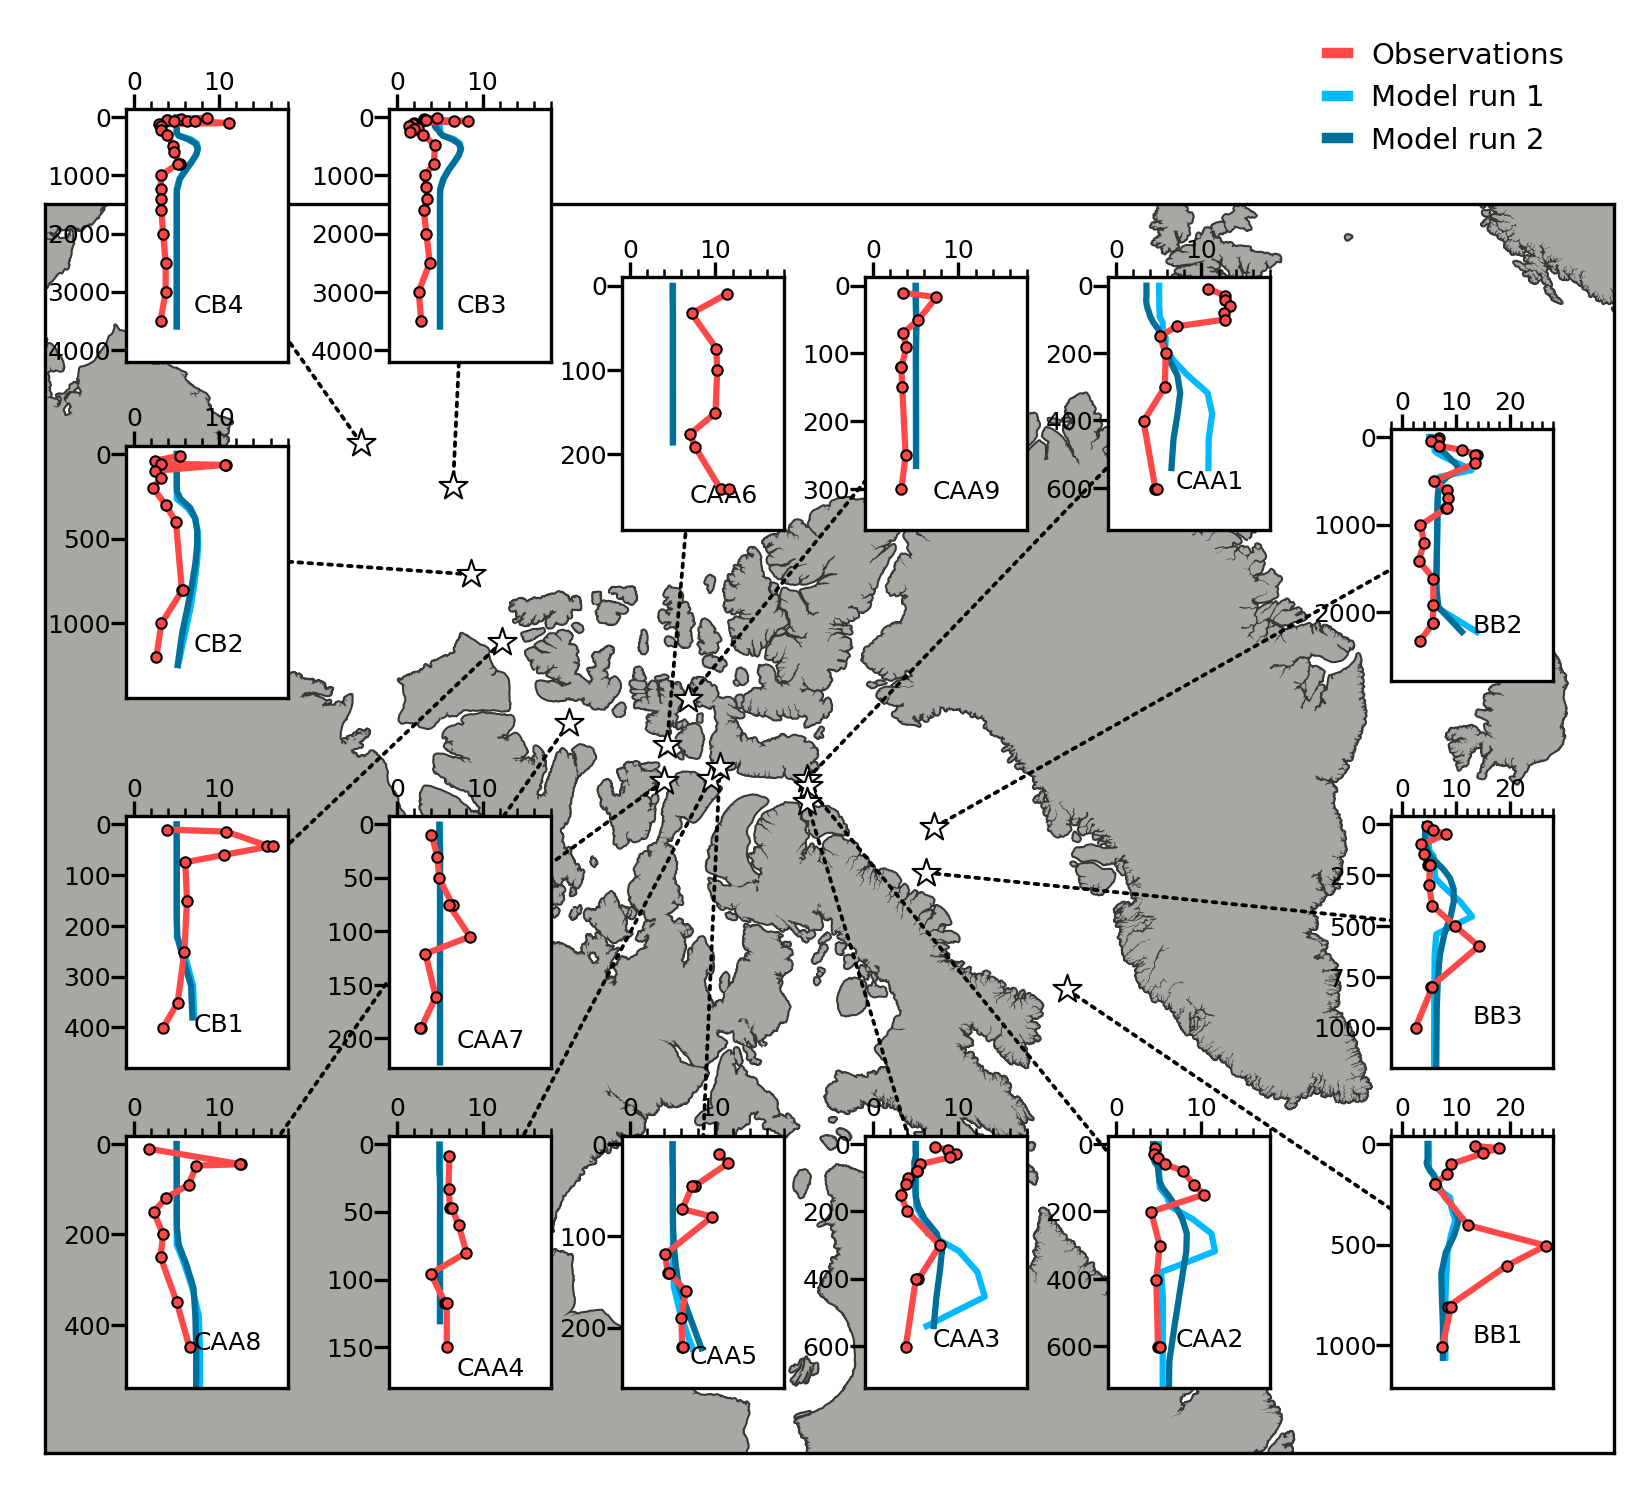

In [52]:
plot_general(Pb_dis1, Pb_dis2, zlim=np.nan)